# Analysis of Meta Active Learning algorithm for node classification

Nodes are selected for acquiring their labels based on meta-gradient of the loss function with respect to a perturbation to the labels.

__Plan__

1. Calculate shortest distances from query nodes to the nodes in training set.

1. Compare average shortest path lengths to nodes with the same label and nodes with a different label

Shortest distance is computed using Dijkstra algorithm.

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

sys.path.append('..')

plot_colors = ['r', 'g', 'b']

datasets = ['cora', 'citeseer', 'pubmed', 'cora-full', 'citeseer_reduced', 'pubmed_reduced', 'amazon_electronics_computers',
           'amazon_electronics_photo', 'ms_academic_cs', 'ms_academic_phy',
           'cora_ml']
data_widget = widgets.Dropdown(options=datasets, disabled=False)
display(data_widget)

Dropdown(options=('cora', 'citeseer', 'pubmed', 'cora-full', 'citeseer_reduced', 'pubmed_reduced', 'amazon_ele…

In [2]:
batch_sizes = ['1', '4', '10', '20', '30']
batch_widget = widgets.Dropdown(options=batch_sizes, disabled=False)
display(batch_widget)

Dropdown(options=('1', '4', '10', '20', '30'), value='1')

In [56]:
all_strategies = ['meta_eps', 'meta', 'meta_weighted','random', 'age', 'bald', 'pagerank', 'degree', 'entropy', 'meta_rand', 'meta_dropout01', 'meta_dropout05', 'meta_weighted_eps', 'meta_dropout08',
'meta_ucb', 'meta_ucb2', 'meta_batch', 'meta_ucb_beta10',
'meta_ucb_beta01', 'meta_ucb_beta05', 'meta_ucb_beta00']

In [81]:
n_trials = 10

gnn_model = 'gcn'
results_dir = f'../results/{gnn_model}'
print("dataset = {}".format(data_widget.value))
data_name = data_widget.value
batch_size = int(batch_widget.value)

data_dir = os.path.join(results_dir, f'batch {batch_size}')

results = {}
# avg_sp_same_label = {}
# avg_sp_dif_label = {}

for strategy in all_strategies:
    file_path = os.path.join(data_dir, '{}_{}_{}trials-accuracy.csv'.format(data_name, strategy.lower(), n_trials))
    if os.path.exists(file_path):
        results[strategy] = np.genfromtxt(file_path, delimiter = ',')

key0 = list(results.keys())[0]
n_epochs = results[key0].shape[0]

dataset = citeseer


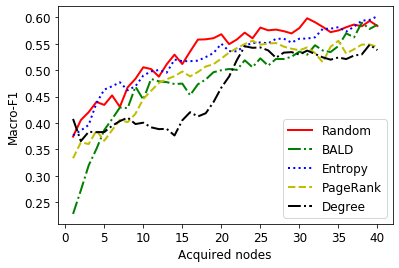

In [83]:
from cycler import cycler

os.makedirs(os.path.join(data_dir, 'figures'), exist_ok=True)

# n_epochs = 20
ablation = False
# strategies = ['meta_dropout08', 'random', 'bald', 'entropy', 'pagerank', 'age']
strategies = ['random', 'bald', 'entropy', 'pagerank', 'degree']
if ablation:
    # strategies = ['meta_ucb', 'meta_ucb_beta10', 'meta_ucb_beta05','meta_ucb_beta01', 'meta_ucb_beta00']
    strategies = [ 'meta_dropout01', 'meta_dropout05', 'meta_dropout08', 'meta_ucb']

colors = ['r', 'g', 'b', 'y', 'k', 'm']
linestyles = ['-', '-.', ':', '--', '-.', ':']
custom_cycler = (cycler(color=colors) +
                  cycler(linestyle=linestyles))

plt.rc('lines', linewidth=4)
plt.rc('axes', prop_cycle=custom_cycler)
plt.rcParams.update({'font.size': 12})

metrics = ['accuracy', 'macro-f1', 'micro-f1']
n_metrics = int(results[key0].shape[1]/n_trials)
performance = {}

metric_id = 1
acquisition_size = list(range(batch_size,(n_epochs+1)*batch_size, batch_size))
label_dic = {'bald':'BALD', 'age':'AGE', 'pagerank':'PageRank', 'random':'Random', 'entropy':'Entropy', 'degree': 'Degree', 'meta':'MetAL (Ours)', 'meta_dropout05':'MetAL (Ours)'}

for idx, strategy in enumerate(strategies):
    if strategy in results.keys():
        label = strategy
        if ablation:
            if strategy.startswith('meta_ucb_beta'):
                gamma = float(strategy[-2:])/10
                label = f'$\gamma$ = {gamma:.1f}'
            elif strategy.startswith('meta_dropout'):
                gamma = float(strategy[-2:])/10
                label = f'dropout ({gamma})'
            else:
                label = r'$\gamma_t \sim Beta(\alpha, \beta_t$)'
        else:
            if strategy in label_dic:
                label = label_dic[strategy]
            elif strategy.startswith('MetAL'):
                label = 'MetAL (Ours)'
        performance = results[strategy][:,metric_id::n_metrics]
        fig = plt.plot(acquisition_size, performance.mean(1)[:n_epochs], label=label, linewidth=2)
    
plt.xlabel('Acquired nodes')
plt.ylabel(metrics[metric_id].title())
# plt.ylim(ymin=0.5)
plt.legend()
plt.savefig(os.path.join(data_dir, f'figures/{data_name}_{batch_size}_{metrics[metric_id]}.pdf'), bbox_inches='tight')
plt.show()

In [42]:
results.keys()

dict_keys(['random', 'age', 'bald', 'pagerank', 'degree', 'entropy', 'meta_weighted_eps', 'meta_ucb'])

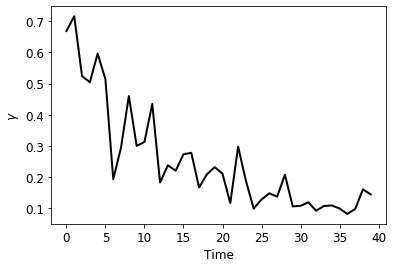

In [476]:
beta = np.vstack([[np.random.beta(1.0, 0.2*(epoch+1)) for epoch in range(40)] for i in range(10)])
beta = np.mean(beta, axis=0)
plt.plot(list(range(40)), beta, color='black', linewidth=2)
plt.xlabel('Time')
plt.ylabel(r'$\gamma$')
plt.savefig(os.path.join(data_dir, f'figures/gamma_dist.pdf'), bbox_inches='tight')

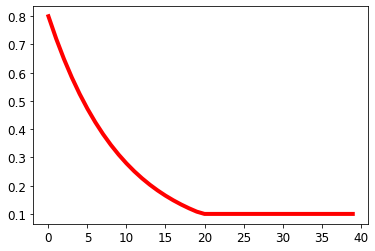

In [422]:
beta = [max(0.1, 0.8 * (0.9**epoch)) for epoch in range(40)]
plt.plot(list(range(40)), beta)

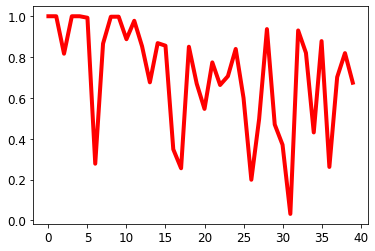

In [270]:
beta = [np.random.beta(1.0, 1.005-0.95**epoch) for epoch in range(40)]
plt.plot(list(range(40)), beta)

In [21]:
# print average variance of each model
for strategy in results:
    print(f'{strategy}: {np.mean(results[strategy][:,metric_id::n_metrics].var(1))}')

meta: 0.0021001047605288493
random: 0.005259527971079267
age: 0.001900693421157572
bald: 0.003231645427607699
pagerank: 0.00279235758446648
entropy: 0.002934312239476341
meta_dropout00: 0.002581017492370447
meta_dropout05: 0.0033734871730730642
meta_weighted_eps: 0.0028109913735528025


In [7]:
results['random'][:,metric_id::n_metrics].mean(1)

array([0.54081781, 0.55186616, 0.54674504, 0.54977697, 0.55927004,
       0.57946991, 0.57697011, 0.58588812, 0.59131108, 0.59813415,
       0.65940822, 0.65219555, 0.661459  , 0.67812938, 0.67926186,
       0.69721695, 0.69619275, 0.70419619, 0.70394425, 0.7123723 ,
       0.71447545, 0.71954338, 0.72109815, 0.72428858, 0.73103565,
       0.73317397, 0.72997834, 0.72717577, 0.72801379, 0.72956578,
       0.731674  , 0.73206052, 0.73677636, 0.74116724, 0.74463883,
       0.74980672, 0.75227761, 0.75497611, 0.76335379, 0.76362728])

In [22]:
results['meta_weighted_eps'][:,metric_id::n_metrics].mean(1)

array([0.53872638, 0.58987473, 0.59734084, 0.60800948, 0.63852919,
       0.62848935, 0.64476378, 0.6532697 , 0.66385822, 0.6763821 ,
       0.68911287, 0.70073278, 0.69962107, 0.71062679, 0.70942946,
       0.72263037, 0.72436337, 0.72537833, 0.74056956, 0.74390649,
       0.74889451, 0.75075869, 0.75888769, 0.76163439, 0.76946274,
       0.77278278, 0.77148946, 0.77093472, 0.77177707, 0.77007984,
       0.77670027, 0.77978817, 0.78058664, 0.78228966, 0.78204192,
       0.77895885, 0.77938954, 0.78282279, 0.7831202 , 0.78316681])

In [23]:
results['bald'][:,metric_id::n_metrics].mean(1)

array([0.56153116, 0.59236253, 0.6132729 , 0.61362514, 0.63932601,
       0.64103425, 0.65216085, 0.65408387, 0.64561495, 0.67926676,
       0.68170991, 0.70006197, 0.70201128, 0.69527424, 0.69755228,
       0.70659428, 0.72158994, 0.73555203, 0.73708364, 0.73739044,
       0.74372484, 0.73107355, 0.73954794, 0.74485037, 0.74269622,
       0.74099182, 0.74164619, 0.74360463, 0.74655029, 0.75239459,
       0.74785372, 0.75563887, 0.7577518 , 0.75995917, 0.76271851,
       0.75558656, 0.75639581, 0.75581486, 0.76231961, 0.75799264])

In [24]:
results['age'][:,metric_id::n_metrics].mean(1)

array([0.57122524, 0.58771631, 0.64233465, 0.63776157, 0.64803368,
       0.68110053, 0.66196771, 0.65824103, 0.67350883, 0.69346106,
       0.6931956 , 0.71239849, 0.70634003, 0.70476557, 0.71002597,
       0.71413439, 0.71322734, 0.71520307, 0.71429368, 0.72735889,
       0.72777078, 0.72472514, 0.72414947, 0.73106992, 0.72856021,
       0.72671153, 0.73143937, 0.73257011, 0.73571514, 0.74122956,
       0.74175341, 0.74281892, 0.74449605, 0.7441087 , 0.74493593,
       0.74610681, 0.74346033, 0.74428791, 0.74497982, 0.74497939])

In [18]:
results['meta_comb_loss'][:,metric_id::n_metrics].mean(1)

array([0.63206882, 0.65817919, 0.68002781, 0.69506047, 0.70501178,
       0.71659702, 0.72698864, 0.7385391 , 0.74742971, 0.75530978,
       0.76287602, 0.76876276, 0.77440847, 0.77957602, 0.78476529])